### Import Libraries

In [101]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import impute
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.tools as tls
from scipy import stats


### Load the Data

In [102]:
path = "employee_attrition_previous_closure.csv"
df = pd.read_csv(path, sep = ",")
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,50.0,No,Travel_Rarely,1126.0,Research & Development,1.0,2,Medical,1,997,...,3,80,1,32,1,2,5,4,1,3
1,36.0,No,Travel_Rarely,216.0,Research & Development,6.0,2,Medical,1,178,...,4,80,2,7,0,3,3,2,0,1
2,21.0,Yes,Travel_Rarely,337.0,Sales,7.0,1,Marketing,1,1780,...,2,80,0,1,3,3,1,0,1,0
3,50.0,No,Travel_Frequently,1246.0,Human Resources,NaN,3,Medical,1,644,...,3,80,1,32,2,3,32,5,10,7
4,52.0,No,Travel_Rarely,994.0,Research & Development,7.0,4,Life Sciences,1,1118,...,4,80,0,18,4,3,8,6,4,0


#### 1.1 Initial Analysis

In [103]:
df_HR = df.copy(deep=True)
df_HR.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [104]:
print("Number of rows: {}, columns: {}".format(df_HR.shape[0], df_HR.shape[1]))

Number of rows: 1029, columns: 35


#### 1.2 Check for NA values

In [105]:
df_HR.isna().sum()

Age                         136
Attrition                     0
BusinessTravel                5
DailyRate                    27
Department                    0
DistanceFromHome             95
Education                     0
EducationField                0
EmployeeCount                 0
EmployeeNumber                0
EnvironmentSatisfaction       0
Gender                        0
HourlyRate                    0
JobInvolvement                0
JobLevel                      0
JobRole                       0
JobSatisfaction               0
MaritalStatus                 5
MonthlyIncome                 0
MonthlyRate                   0
NumCompaniesWorked            0
Over18                        0
OverTime                      0
PercentSalaryHike             0
PerformanceRating             0
RelationshipSatisfaction      0
StandardHours                 0
StockOptionLevel              0
TotalWorkingYears             0
TrainingTimesLastYear         0
WorkLifeBalance               0
YearsAtC

In [106]:
df_HR.isnull().sum().sum()

268

#### 1.3 Drop some columns
1. Drop columns which have legacy information - DailyRate, HourlyRate, MonthlyRate
2. Drop columns with zero variance - Over18, EmployeeCount, StandardHours
3. Dropping employee number as it gives no information


In [107]:

df_HR.drop(["DailyRate", "MonthlyRate", "HourlyRate", "Over18", "EmployeeCount", "StandardHours", "EmployeeNumber"], axis=1, inplace=True)
df_HR.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,50.0,No,Travel_Rarely,Research & Development,1.0,2,Medical,4,Male,3,...,4,3,1,32,1,2,5,4,1,3
1,36.0,No,Travel_Rarely,Research & Development,6.0,2,Medical,2,Male,3,...,4,4,2,7,0,3,3,2,0,1
2,21.0,Yes,Travel_Rarely,Sales,7.0,1,Marketing,2,Male,3,...,3,2,0,1,3,3,1,0,1,0
3,50.0,No,Travel_Frequently,Human Resources,NaN,3,Medical,1,Male,3,...,3,3,1,32,2,3,32,5,10,7
4,52.0,No,Travel_Rarely,Research & Development,7.0,4,Life Sciences,2,Male,3,...,3,4,0,18,4,3,8,6,4,0


#### 1.4 Impute missing values in Age
Here we assume that people start their first work at 20 years of age. We use the values in the TotalWorkingYears column and add 20 to it to compute the missing age values.

In [108]:
df_HR.loc[df_HR["Age"].isna(), 'Age'] = df_HR.loc[df_HR["Age"].isna(),"TotalWorkingYears"]+20

#### 1.5 Impute missing values in DistanceFromHome
Here we impute missing values in DistanceFromHome with the mean values

In [109]:
mean_imp = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
df_HR[["DistanceFromHome"]]=mean_imp.fit_transform(df_HR[["DistanceFromHome"]])

# df_HR["DistanceFromHome"].fillna(df_HR["DistanceFromHome"].mean(), inplace=True)

#### 1.6 Imputing MaritalStatus, BusinessTravel missing values with mode

In [110]:
mode_imp = impute.SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_HR[["MaritalStatus"]]=mode_imp.fit_transform(df_HR[["MaritalStatus"]])

df_HR[["BusinessTravel"]]=mode_imp.fit_transform(df_HR[["BusinessTravel"]])

In [111]:
df_HR.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

#### 1.6 Check for duplicates

In [112]:
df_HR.duplicated().sum()

0

#### 1.7 Remove other rows with missing values where the count is too less

In [113]:
df_HR.isna().sum().sum()

0

#### 1.8 Convert Attrition to numerical values

In [114]:
df_HR.Attrition.replace(to_replace = dict(Yes = 1, No = 0), inplace = True)
df_HR['Attrition'].value_counts()

0    853
1    176
Name: Attrition, dtype: int64

In [115]:
df_HR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1029 non-null   float64
 1   Attrition                 1029 non-null   int64  
 2   BusinessTravel            1029 non-null   object 
 3   Department                1029 non-null   object 
 4   DistanceFromHome          1029 non-null   float64
 5   Education                 1029 non-null   int64  
 6   EducationField            1029 non-null   object 
 7   EnvironmentSatisfaction   1029 non-null   int64  
 8   Gender                    1029 non-null   object 
 9   JobInvolvement            1029 non-null   int64  
 10  JobLevel                  1029 non-null   int64  
 11  JobRole                   1029 non-null   object 
 12  JobSatisfaction           1029 non-null   int64  
 13  MaritalStatus             1029 non-null   object 
 14  MonthlyI

###  Exploratory data analysis

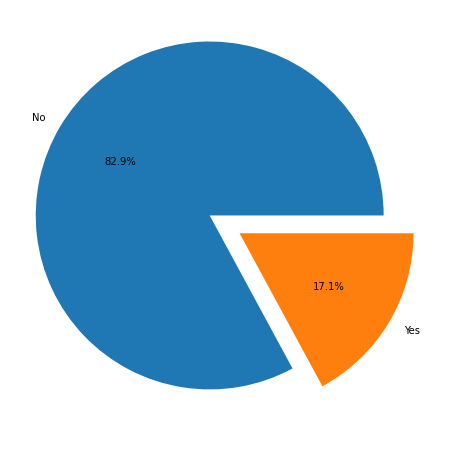

In [116]:
# Check how attrition is distributed in the previous transaction dataset
plt.figure(figsize=(8,8))
pie = df_HR.groupby('Attrition')['Attrition'].count()
plt.pie(pie, explode=[0.1, 0.1], labels=['No', 'Yes'], autopct='%1.1f%%')
plt.show()

In [117]:
# check categorical variables distribution
df_cols=df_HR.select_dtypes(include=object).columns.tolist()
cols_df=pd.DataFrame(df_HR[df_cols].melt(var_name='column', value_name='value')
                    .value_counts()).rename(columns={0: 'count'}).sort_values(by=['column', 'count'])
display(df_HR.select_dtypes(include=object).describe())
display(cols_df)

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime
count,1029,1029,1029,1029,1029,1029,1029
unique,3,3,6,2,9,3,2
top,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,No
freq,728,676,426,617,217,479,731


count
column         value                           
BusinessTravel Non-Travel                   102
               Travel_Frequently            199
               Travel_Rarely                728
Department     Human Resources               42
               Sales                        311
               Research & Development       676
EducationField Human Resources               17
               Other                         66
               Technical Degree              82
               Marketing                    110
               Medical                      328
               Life Sciences                426
Gender         Female                       412
               Male                         617
JobRole        Human Resources               34
               Research Director             62
               Sales Representative          66
               Manager                       73
               Healthcare Representative     89
               Manufacturing Director        95
               Laboratory Technician        179
               Research Scientist           214
               Sales Executive              217
MaritalStatus  Divorced                     230
               Single                       320
               Married                      479
OverTime       Yes                          298
               No                           731

In [118]:
# Check the numerical columns
numerical = df_HR.select_dtypes(include=['float64','int64'])
numerical.columns

Index(['Age', 'Attrition', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

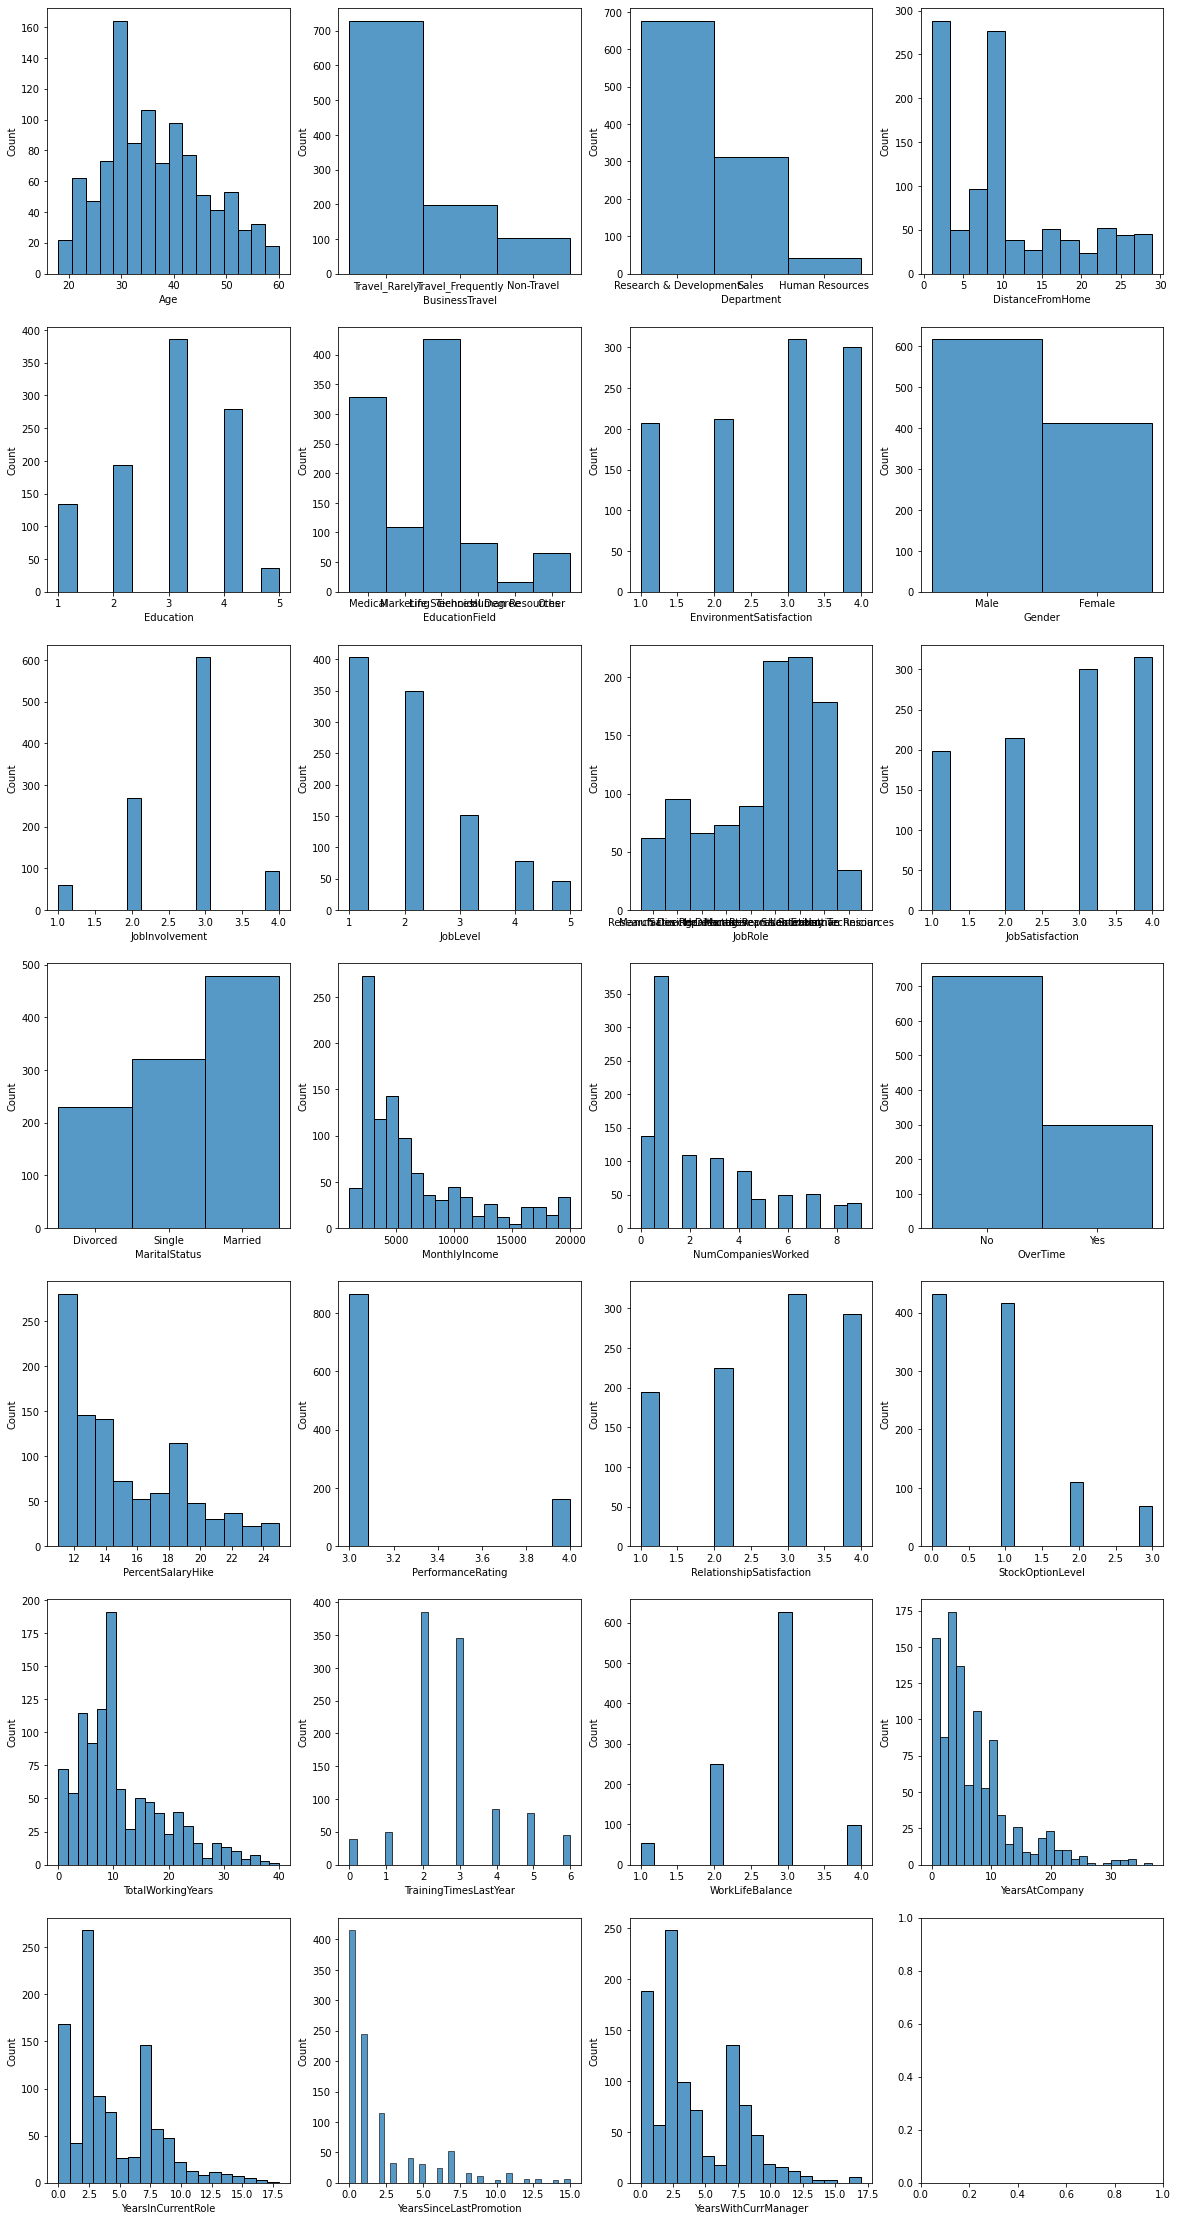

In [119]:
# Histogram plots of all columns to see the general distribution
fig = plt.subplots(7, 4, figsize=(20,40))
count = 1
for col in df_HR.columns:
    if col in ["Attrition", "EmployeeNumber"]:
        continue
    ax = plt.subplot(7, 4, count)
    sns.histplot(df_HR[col])
    count += 1


In [120]:
df_HR[['Age']].value_counts().sort_values(ascending=False)

Age 
30.0    62
29.0    54
36.0    52
34.0    48
31.0    48
33.0    43
32.0    42
27.0    41
40.0    39
38.0    38
42.0    35
37.0    34
41.0    32
45.0    29
39.0    27
43.0    26
25.0    25
21.0    24
26.0    22
24.0    22
46.0    22
50.0    21
23.0    20
55.0    19
22.0    18
51.0    17
44.0    16
52.0    15
53.0    15
48.0    14
49.0    14
54.0    13
47.0    13
56.0    10
28.0    10
20.0    10
58.0     8
19.0     7
59.0     7
35.0     6
18.0     5
57.0     3
60.0     3
dtype: int64

#### Check outliers

In [121]:
# Checking for outliers using z- score and then with box plots to see if there is really any outlier.
# Although Z score gave some outliers, box plots show that the data for these is within bounds and not wrong

df_HR_copy = df_HR.copy(deep=True)
for col in df_HR.columns:
    if col == "Attrition":
        continue
    if df_HR_copy[col].dtype in ['float64','int64']:
        df_HR_copy[col + "_z"] = stats.zscore(df_HR_copy[col], nan_policy="omit") # compute z-score table

        print("outliers in: ", col, " :", df_HR_copy.loc[(df_HR_copy[col + "_z"] > 3) | (df_HR_copy[col + "_z"] < -3), col+"_z"].count())

outliers in:  Age  : 0
outliers in:  DistanceFromHome  : 0
outliers in:  Education  : 0
outliers in:  EnvironmentSatisfaction  : 0
outliers in:  JobInvolvement  : 0
outliers in:  JobLevel  : 0
outliers in:  JobSatisfaction  : 0
outliers in:  MonthlyIncome  : 0
outliers in:  NumCompaniesWorked  : 0
outliers in:  PercentSalaryHike  : 0
outliers in:  PerformanceRating  : 0
outliers in:  RelationshipSatisfaction  : 0
outliers in:  StockOptionLevel  : 0
outliers in:  TotalWorkingYears  : 11
outliers in:  TrainingTimesLastYear  : 0
outliers in:  WorkLifeBalance  : 0
outliers in:  YearsAtCompany  : 16
outliers in:  YearsInCurrentRole  : 9
outliers in:  YearsSinceLastPromotion  : 24
outliers in:  YearsWithCurrManager  : 9


<AxesSubplot:>

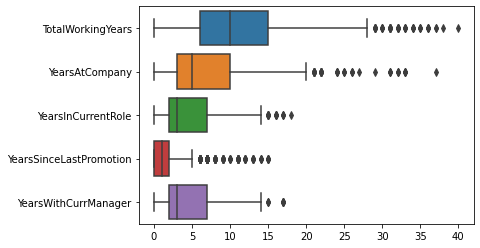

In [122]:
sns.boxplot(data = df_HR_copy[["TotalWorkingYears", "YearsAtCompany", "YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager"]], orient="h")

<AxesSubplot:>

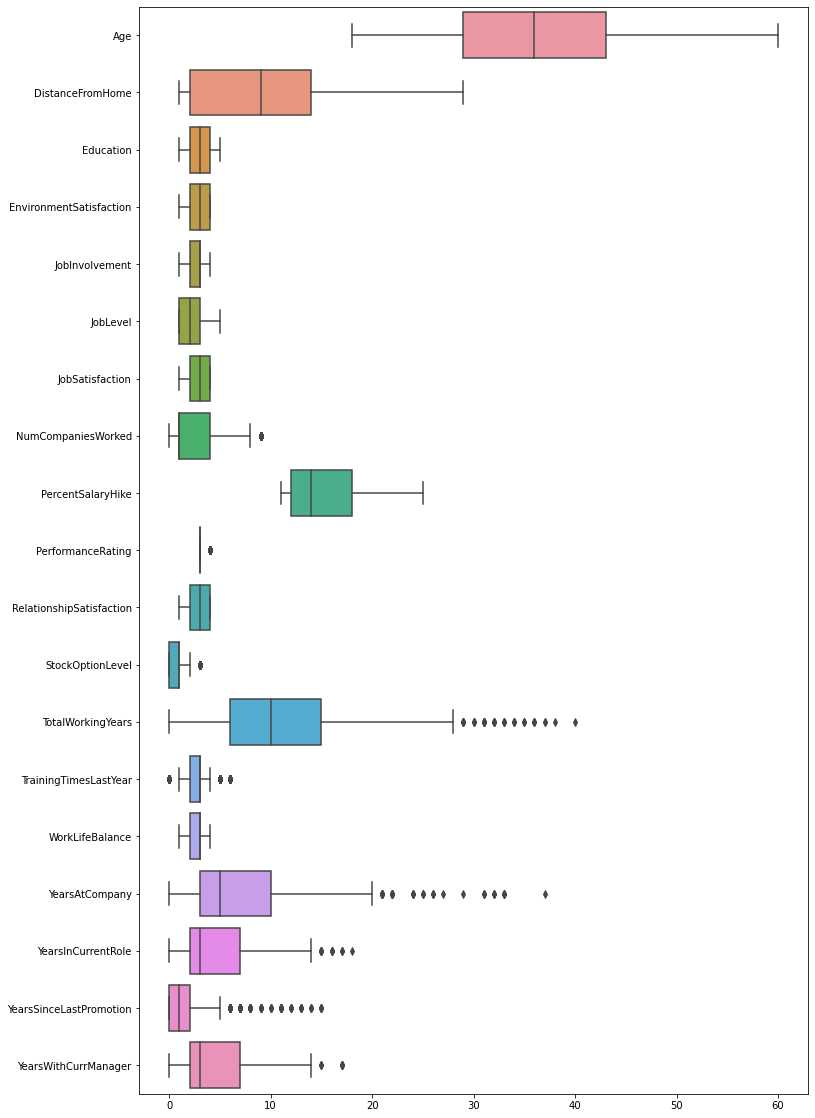

In [123]:
_, _ = plt.subplots(1,1, figsize=(12,20))
sns.boxplot(data = df_HR.drop(["MonthlyIncome", "Attrition"], axis=1), orient="h")

In [124]:
(df_HR["YearsAtCompany"] >= df_HR["YearsInCurrentRole"]).sum()
# df_HR.shape

1029

<AxesSubplot:>

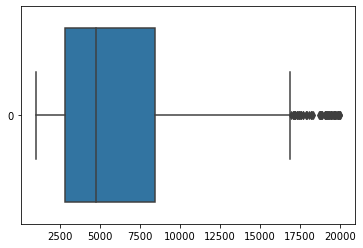

In [125]:
sns.boxplot(data = df_HR["MonthlyIncome"], orient="h")

### Feature Engineering

In [126]:
# calculating a new feature called Average satisfaction combining the existing five columns related to satistifaction (Environment, Job, Relationship, JobInvolvement, WorkLifeBalance)
# calculating another two features stability and fidelity as well
# As monthly income is skewed, applying log to its values


def feature_engineering(data_frame):
    # Merge satisfaction levels
    data_frame["AverageSatisfaction"] = (data_frame["EnvironmentSatisfaction"] + data_frame["JobSatisfaction"] + 
                                         data_frame["RelationshipSatisfaction"] + data_frame["JobInvolvement"] + 
                                         data_frame["WorkLifeBalance"]) / 5
    data_frame.drop(["EnvironmentSatisfaction","JobSatisfaction","RelationshipSatisfaction","JobInvolvement","WorkLifeBalance"], axis=1, inplace=True)

    # Create new feature
    data_frame['Stability'] = data_frame['YearsInCurrentRole'] / data_frame['YearsAtCompany']
    data_frame['Stability'].fillna(1, inplace=True)
    data_frame['Fidelity'] = data_frame['NumCompaniesWorked'] / data_frame['TotalWorkingYears']
    data_frame['Fidelity'].fillna(1, inplace=True)
    data_frame['Fidelity'].replace([np.inf, -np.inf], 1, inplace=True)

   

    data_frame["MonthlyIncome"] = data_frame["MonthlyIncome"].apply(np.log)

In [127]:
feature_engineering(df_HR)

<AxesSubplot:>

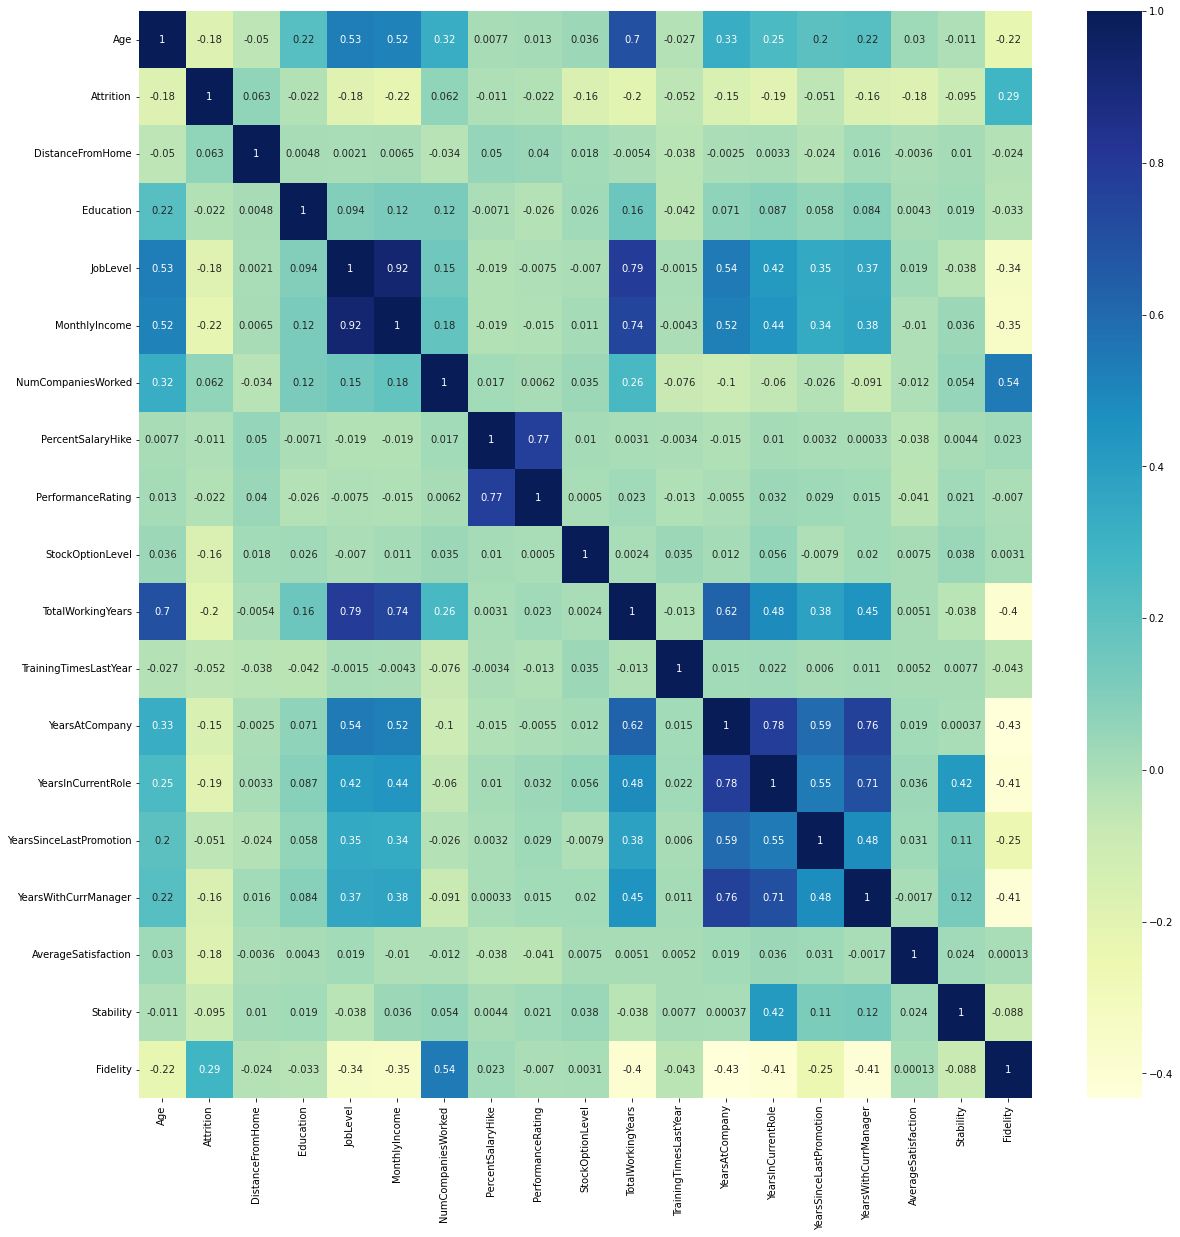

In [128]:
# Looking at correlation matrix to get an idea of the data
plt.figure(figsize=(20,20))
sns.heatmap(df_HR.corr(), annot=True, cmap="YlGnBu")

In [129]:
# Performing binary encoding on Gender, Overtime
# Performing ordinal encoding on BusinessTravel
# Performing one- hot encoding on the remaining categorical variables

# Removing Performance Rating from the columns list as the ratings are mostly 3 for the maximum employees

def encode_features(data_frame):
    # get categorical and numerical features
    numeric_columns = []
    categorical_columns = []
    for col in data_frame.columns:
        if data_frame[col].dtype in ["int64", "float64"]:
            numeric_columns.append(col)
        else:
            categorical_columns.append(col)

    # Binary, Ordinal, Nominal, Dummy
    data_frame.Gender.replace(to_replace = dict(Male = 0, Female = 1), inplace = True)

    data_frame.OverTime.replace(to_replace = dict(Yes = 1, No = 0), inplace = True)
    data_frame.BusinessTravel.replace(to_replace = {"Non-Travel": 1, "Travel_Rarely": 2, "Travel_Frequently": 3}, inplace = True)

    categorical_columns.remove("Gender")
    categorical_columns.remove("OverTime")
    categorical_columns.remove("BusinessTravel")

    data_frame = pd.get_dummies(data_frame, drop_first=False, columns=categorical_columns)
    if "Attrition" in data_frame.columns:
         numeric_columns.remove("Attrition")
         
    numeric_columns.remove("PerformanceRating")
    data_frame.drop(["PerformanceRating"], axis=1, inplace=True)

    return data_frame, numeric_columns, categorical_columns


### Test Train Split

In [130]:
# Train- Test split in 4:1 ratio
df_HR, numeric_columns, categorical_columns =  encode_features(df_HR)

X = df_HR.drop(["Attrition"], axis=1, inplace=False)
y = df_HR["Attrition"]

# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 420, stratify=y)


In [131]:
# Standardization
scaler = preprocessing.StandardScaler()
scaler.fit(X_train[numeric_columns])
X_train[numeric_columns] = scaler.transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

### Model fit
Logistic Regression, CART, Random Forest, Gradient Boost

In [132]:
def plot_importances(classifier):
    importances = classifier.feature_importances_
    indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
    names = [X_train.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances
    plt.figure(figsize=(15, 7)) 
    plt.title("Feature Importance") 
    plt.bar(range(X_train.shape[1]), importances[indices]) 
    plt.xticks(range(X_train.shape[1]), names, rotation=90) 
    plt.show() 

In [133]:
def fit_predict_and_plot(classifier, type=None):
    y_pred_prob = classifier.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    print("ROC AUC: ", metrics.roc_auc_score(y_test, y_pred_prob))

    y_pred = classifier.predict(X_test)
    print("Accuracy score: {}".format(metrics.accuracy_score(y_test, y_pred)))
    plt.plot(fpr, tpr, linewidth=4)

    if type == "logistic":
        # Coefficients of the model
        summary = pd.DataFrame([X_train.columns,classifier.coef_[0]]).T.sort_values(by = 1, ascending = False)
        summary.columns = ['Variable','Coefficient']
        print(summary)

    plt.show()

#### Logistic Regression

Best params:  {'C': 1, 'class_weight': None, 'penalty': 'l2'}
ROC AUC:  0.8902255639097745
Accuracy score: 0.912621359223301
                             Variable Coefficient
8                            OverTime    1.786113
1                      BusinessTravel    0.605417
15            YearsSinceLastPromotion    0.451181
37       JobRole_Sales Representative    0.437117
31      JobRole_Laboratory Technician    0.411397
5                            JobLevel    0.387247
13                     YearsAtCompany    0.357304
19                           Fidelity    0.346899
2                    DistanceFromHome    0.303595
23     EducationField_Human Resources    0.290139
7                  NumCompaniesWorked    0.271016
28    EducationField_Technical Degree    0.179339
40               MaritalStatus_Single    0.108508
3                           Education    0.016824
9                   PercentSalaryHike    -0.03257
30            JobRole_Human Resources   -0.097557
0                        

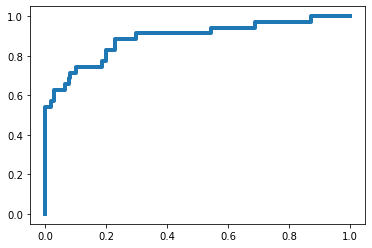

In [134]:
# Logistics regression
def fit_logistic_regression(plot_coeffs=True):
    classifier_lr = LogisticRegression(
        max_iter=2000,
        solver='liblinear')

    parameters_lr = {
        'penalty': ['l1', 'l2'],
        'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
        'class_weight': ['balanced', None]
    }

    clf_lr = GridSearchCV(classifier_lr, parameters_lr, scoring="roc_auc", cv=5)
    clf_lr.fit(X_train, y_train.values.ravel())
    print("Best params: ", clf_lr.best_params_)
    classifier_lr_best = clf_lr.best_estimator_
    classifier_lr_best.fit(X_train, y_train.values.ravel())
    if plot_coeffs:
        fit_predict_and_plot(classifier_lr_best, "logistic")
    else:
        fit_predict_and_plot(classifier_lr_best)

    return classifier_lr_best

classifier_lr_best = fit_logistic_regression()

### Random Forest

Best params:  {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100}
ROC AUC:  0.8548036758563075
Accuracy score: 0.8640776699029126


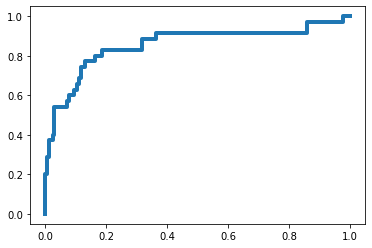

<Figure size 432x288 with 0 Axes>

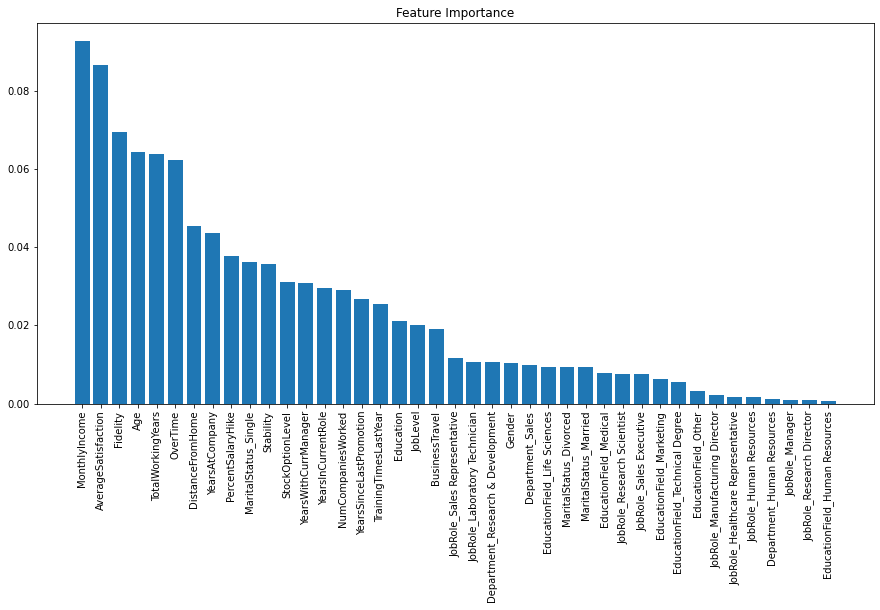

In [135]:
def fit_random_forest(importance_plot=True):
    classifier_rf = RandomForestClassifier(random_state=7)
    parameters_rf = {'n_estimators': [100, 125],
                  'min_samples_split':[6, 8],
                  'min_samples_leaf': [1, 2],
                  'max_depth': [10, 15],
                  'class_weight': ['balanced', None]}

    clf_rf = GridSearchCV(classifier_rf,
                            return_train_score=True,
                            param_grid=parameters_rf,
                            scoring='roc_auc',
                            cv=5)
    clf_rf.fit(X_train, y_train.values.ravel())
    print("Best params: ", clf_rf.best_params_)
    classifier_rf_best = clf_rf.best_estimator_
    classifier_rf_best.fit(X_train, y_train.values.ravel())
    fit_predict_and_plot(classifier_rf_best)

    if importance_plot:
        plt.figure()
        plot_importances(classifier_rf_best)
    return classifier_rf_best
classifier_rf_best = fit_random_forest()

#### CART

Best params:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'random'}
ROC AUC:  0.7895572263993317
Accuracy score: 0.8495145631067961


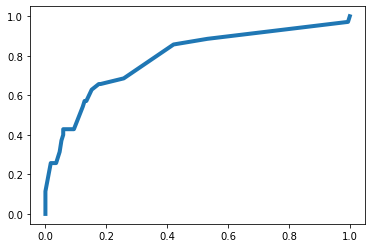

<Figure size 432x288 with 0 Axes>

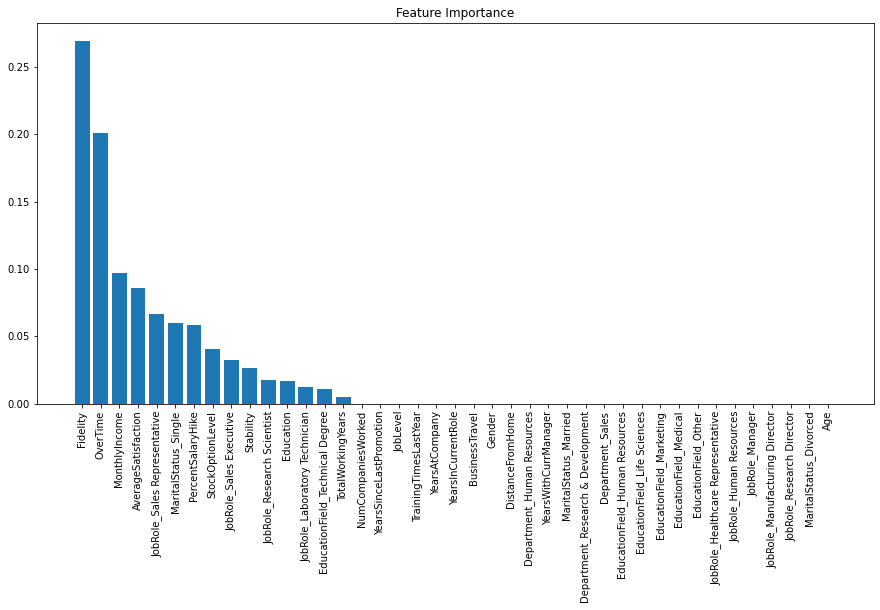

In [136]:
def fit_cart(importance_plot=True):
    classifier_dt = DecisionTreeClassifier(random_state=42)
    parameters_dt = {
        "criterion":("gini", "entropy"), 
        "splitter":("best", "random"), 
        "max_depth":[5, 10], 
        "min_samples_split":[2, 3, 4], 
        "min_samples_leaf":[5, 10], 
    }

    clf_dt = GridSearchCV(classifier_dt,
                            return_train_score=True,
                            param_grid=parameters_dt,
                            scoring='roc_auc',
                            cv=5)
    clf_dt.fit(X_train, y_train.values.ravel())
    print("Best params: ", clf_dt.best_params_)
    classifier_dt_best = clf_dt.best_estimator_
    fit_predict_and_plot(classifier_dt_best)

    if importance_plot:
        plt.figure()
        plot_importances(classifier_dt_best)    

classifier_dt_best = fit_cart()

#### Gradient Boost

Best params:  {'criterion': 'squared_error', 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
ROC AUC:  0.8317460317460317
Accuracy score: 0.8495145631067961


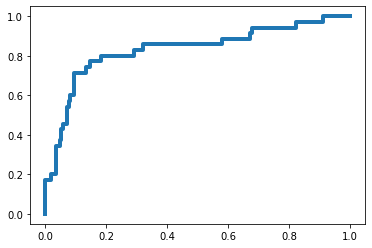

<Figure size 432x288 with 0 Axes>

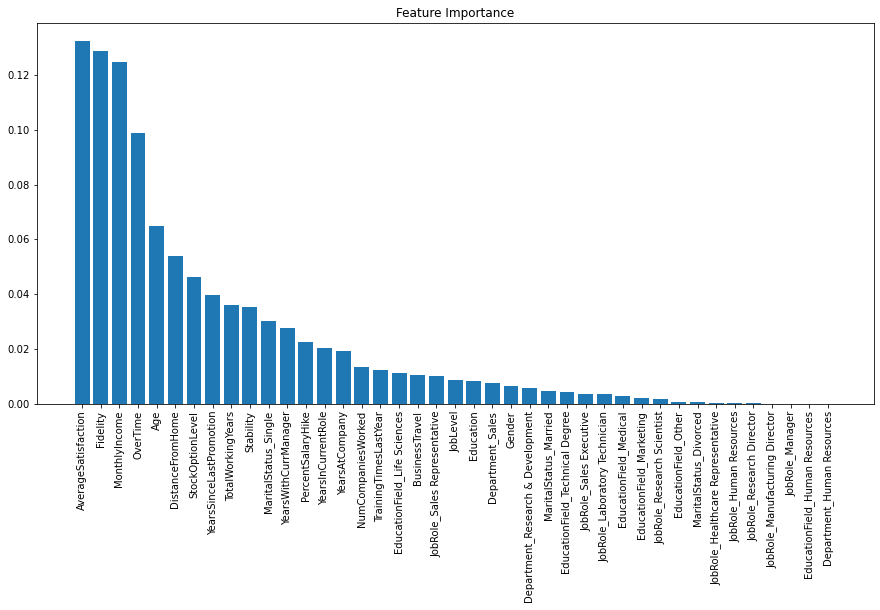

In [137]:
def fit_gradient_boost(importance_plot=True):
    classifier_gb = GradientBoostingClassifier(random_state=42)
    parameters_gb = {
        "learning_rate":[0.1, 0.01, 0.001],
        "criterion":('friedman_mse', 'squared_error'),
        "max_depth":[5, 10], 
        "min_samples_split":[2, 3, 4], 
        "min_samples_leaf":[5, 10], 
    }

    clf_gb = GridSearchCV(classifier_gb,
                            return_train_score=True,
                            param_grid=parameters_gb,
                            scoring='roc_auc',
                            cv=5)
    clf_gb.fit(X_train, y_train.values.ravel())
    print("Best params: ", clf_gb.best_params_)
    classifier_gb_best = clf_gb.best_estimator_
    fit_predict_and_plot(classifier_gb_best)

    if importance_plot:
        plt.figure()
        plot_importances(classifier_gb_best)

classifier_gb_best = fit_gradient_boost()

#### Trying PCA to see if it gives better performance

In [138]:
from sklearn import decomposition as dcp

df_HR_2 = df_HR.drop(["Attrition"], axis=1)

pca=dcp.PCA(n_components=df_HR_2.shape[1])
pca.fit(df_HR_2)

PCA(n_components=41)

In [139]:
pca.components_

array([[ 6.99985446e-01, -2.94041554e-04, -3.39069675e-02, ...,
         9.53244112e-04,  3.19597104e-03, -4.14921515e-03],
       [-6.60514856e-02, -9.75493840e-04,  9.88946630e-01, ...,
         2.56008707e-04,  5.25350255e-04, -7.81358962e-04],
       [ 5.65122194e-01, -9.51434154e-04,  1.37830108e-01, ...,
        -1.40609364e-03,  1.96284945e-03, -5.56755809e-04],
       ...,
       [-0.00000000e+00,  3.88578059e-16,  1.34144870e-17, ...,
         3.30277322e-01,  3.30277322e-01,  3.30277322e-01],
       [ 0.00000000e+00,  2.08166817e-17,  3.53755888e-18, ...,
        -8.17890893e-02, -8.17890893e-02, -8.17890893e-02],
       [-0.00000000e+00,  2.77555756e-17, -9.01648234e-18, ...,
        -1.87695100e-01, -1.87695100e-01, -1.87695100e-01]])

In [140]:
pca.explained_variance_

array([1.52264310e+02, 6.46753511e+01, 4.84790084e+01, 1.48403365e+01,
       1.34075578e+01, 5.98758018e+00, 5.27054836e+00, 3.95906276e+00,
       3.70772599e+00, 1.64288655e+00, 1.05087112e+00, 9.15672121e-01,
       7.90735241e-01, 4.79911492e-01, 3.57737129e-01, 3.44354127e-01,
       2.91584842e-01, 2.30462397e-01, 2.11477272e-01, 1.77480550e-01,
       1.72985869e-01, 1.41029798e-01, 1.23701354e-01, 1.12740526e-01,
       9.92939785e-02, 8.81925079e-02, 8.68580375e-02, 7.45741893e-02,
       6.34879911e-02, 6.13540378e-02, 5.71792023e-02, 4.26214968e-02,
       3.80071570e-02, 1.60666570e-02, 1.12373752e-02, 7.17578066e-03,
       3.67345558e-03, 9.29540077e-31, 9.29540077e-31, 9.29540077e-31,
       9.29540077e-31])

In [141]:
pca.explained_variance_ratio_

array([4.75402810e-01, 2.01930733e-01, 1.51362173e-01, 4.63348088e-02,
       4.18613573e-02, 1.86945480e-02, 1.64558162e-02, 1.23610685e-02,
       1.15763396e-02, 5.12945473e-03, 3.28105177e-03, 2.85893063e-03,
       2.46885009e-03, 1.49838969e-03, 1.11693434e-03, 1.07514965e-03,
       9.10392287e-04, 7.19554511e-04, 6.60278760e-04, 5.54133483e-04,
       5.40100095e-04, 4.40326184e-04, 3.86222952e-04, 3.52000827e-04,
       3.10017735e-04, 2.75356491e-04, 2.71189980e-04, 2.32837092e-04,
       1.98223533e-04, 1.91560859e-04, 1.78526101e-04, 1.33073728e-04,
       1.18666740e-04, 5.01636523e-05, 3.50855677e-05, 2.24043723e-05,
       1.14693398e-05, 2.90222945e-33, 2.90222945e-33, 2.90222945e-33,
       2.90222945e-33])

In [142]:
pca.explained_variance_ratio_.sum()

0.9999999999999999

In [143]:
explained_variance_ratio_cumul_sum=np.cumsum(pca.explained_variance_ratio_)
explained_variance_ratio_cumul_sum

array([0.47540281, 0.67733354, 0.82869572, 0.87503053, 0.91689188,
       0.93558643, 0.95204225, 0.96440332, 0.97597965, 0.98110911,
       0.98439016, 0.98724909, 0.98971794, 0.99121633, 0.99233327,
       0.99340842, 0.99431881, 0.99503836, 0.99569864, 0.99625277,
       0.99679287, 0.9972332 , 0.99761942, 0.99797142, 0.99828144,
       0.9985568 , 0.99882799, 0.99906083, 0.99925905, 0.99945061,
       0.99962914, 0.99976221, 0.99988088, 0.99993104, 0.99996613,
       0.99998853, 1.        , 1.        , 1.        , 1.        ,
       1.        ])

In [144]:
# fit pca and take the top principal components
x_pca = pca.fit_transform(df_HR_2)
df_pca = pd.DataFrame(x_pca)

# x and y
X_pca_chosen = df_pca[[0, 1, 2, 3, 4]]
y = df_HR["Attrition"]

# test and train split
X_train, X_test, y_train, y_test = train_test_split(X_pca_chosen, y, test_size=0.2, random_state = 420, stratify=y)

# Standardization
scaler_pca = preprocessing.StandardScaler()
scaler_pca.fit(X_train)
X_train = scaler_pca.transform(X_train)
X_test = scaler_pca.transform(X_test)


Best params:  {'C': 0.1, 'class_weight': None, 'penalty': 'l1'}
ROC AUC:  0.6761904761904762
Accuracy score: 0.8300970873786407


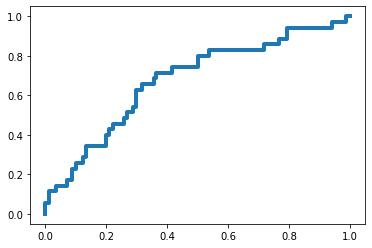

Best params:  {'class_weight': None, 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100}
ROC AUC:  0.6852130325814537
Accuracy score: 0.8349514563106796


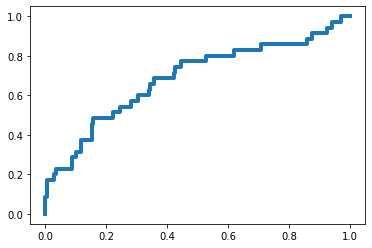

Best params:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'best'}
ROC AUC:  0.7063492063492065
Accuracy score: 0.8398058252427184


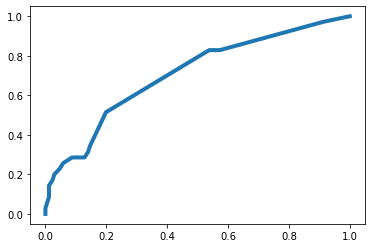

In [145]:
classifier_lr_pca_best = fit_logistic_regression(False)
classifier_rf_pca_best = fit_random_forest(False)
classifier_dt_pca_best = fit_cart(False)

#### Observations made from the analysis of different models: 

- Tried four different models (Logistic, CART, Random Forest, Gradient Boost) and also with PCA selection of features on the first three models
- Comparision metric here is with AUC as the objective is to just predict the probability of employee leaving. The normal logistic regression gave the best AUC (89.02)
- Will be using this logistic model to predict the probability of employees leaving in Y dataset

In [146]:
# Predict on the data of C
path = "employee_attrition_y.csv"
y_df = pd.read_csv(path, sep = ",")
y_df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,NaN,Travel_Rarely,866.0,Sales,NaN,3,Medical,1,1469,4,...,4,80,0,6,4,3,5,4,1,3
1,53.0,Travel_Rarely,1084.0,Research & Development,13.0,2,Medical,1,250,4,...,3,80,2,5,3,3,4,2,1,3
2,24.0,Travel_Rarely,240.0,Human Resources,22.0,1,Human Resources,1,1714,4,...,3,80,1,1,2,3,1,0,0,0
3,45.0,Travel_Rarely,1339.0,Research & Development,7.0,3,Life Sciences,1,86,2,...,3,80,1,25,2,3,1,0,0,0
4,36.0,Travel_Rarely,1396.0,Research & Development,NaN,2,Life Sciences,1,304,4,...,4,80,0,16,3,4,13,11,3,7


In [147]:
# checking for missing values
y_df.isna().sum()

Age                         55
BusinessTravel               5
DailyRate                   14
Department                   0
DistanceFromHome            54
Education                    0
EducationField               0
EmployeeCount                0
EmployeeNumber               0
EnvironmentSatisfaction      0
Gender                       0
HourlyRate                   0
JobInvolvement               0
JobLevel                     0
JobRole                      0
JobSatisfaction              0
MaritalStatus                3
MonthlyIncome                0
MonthlyRate                  0
NumCompaniesWorked           0
Over18                       0
OverTime                     0
PercentSalaryHike            0
PerformanceRating            0
RelationshipSatisfaction     0
StandardHours                0
StockOptionLevel             0
TotalWorkingYears            0
TrainingTimesLastYear        0
WorkLifeBalance              0
YearsAtCompany               0
YearsInCurrentRole           0
YearsSin

In [148]:
# dropping irrelevant columns
y_df.drop(["DailyRate", "MonthlyRate", "HourlyRate", "Over18", "EmployeeCount", "StandardHours", "EmployeeNumber"], axis=1, inplace=True)


In [149]:
# Imputing missing values

y_df.loc[y_df["Age"].isna(), 'Age'] = y_df.loc[y_df["Age"].isna(),"TotalWorkingYears"]+20

In [150]:
y_df[["MaritalStatus"]]=mode_imp.fit_transform(y_df[["MaritalStatus"]])

y_df[["BusinessTravel"]]=mode_imp.fit_transform(y_df[["BusinessTravel"]])
y_df[["DistanceFromHome"]]=mean_imp.fit_transform(y_df[["DistanceFromHome"]])


In [151]:
y_df.isna().sum()

Age                         0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

In [152]:
# Feature Engineering
feature_engineering(y_df)
y_df, numeric_columns, categorical_columns =  encode_features(y_df)


In [153]:
# scale with the same scaler as before
y_df[numeric_columns] = scaler.transform(y_df[numeric_columns])

### Question 1 :

In [154]:
# Predicting the probabilities of employees leaving if RCC offered and printing it as a list
y_y = classifier_lr_best.predict_proba(y_df)[:,1]
print(list(y_y))


[0.033022440525487355, 0.00857235155285651, 0.7105446919889177, 0.010954466504447261, 0.04034312202949224, 0.2392980318353587, 0.1469966986989225, 0.07763005400867935, 0.056220820050409986, 0.05955770011891765, 0.45164157142657596, 0.044566685447621414, 0.11752214838551013, 0.03431335788726551, 0.011151256358002038, 0.040819824889365135, 0.07943417806603367, 0.14096792281420956, 0.1960943456377599, 0.062434239998165074, 0.3453101177590873, 0.006865380087330024, 0.03067456144444462, 0.3446241425875679, 0.05618938128786369, 0.029998790671628764, 0.0840237795089904, 0.024138517944641738, 0.08343603523000523, 0.03417388548980147, 0.012705413548656291, 0.00652106935649902, 0.0046570463062740215, 0.0277985632414761, 0.4036348551689757, 0.009438568622396153, 0.0011030141443610115, 0.5755781317530437, 0.7789007372357114, 0.02067356617441065, 0.026971956717177607, 0.09955130335985905, 0.07465206865057582, 0.12606888384272744, 0.8784797392142053, 0.008990525830889272, 0.6966199309374317, 0.51618

In [155]:
# Best params:  {'C': 1, 'class_weight': None, 'penalty': 'l2'}
# ROC AUC:  0.8902255639097745
# Accuracy score: 0.912621359223301
#                              Variable Coefficient
# 8                            OverTime    1.786113
# 1                      BusinessTravel    0.605417
# 15            YearsSinceLastPromotion    0.451181
# 37       JobRole_Sales Representative    0.437117
# 31      JobRole_Laboratory Technician    0.411397
# 5                            JobLevel    0.387247
# 13                     YearsAtCompany    0.357304
# 19                           Fidelity    0.346899
# 2                    DistanceFromHome    0.303595
# 23     EducationField_Human Resources    0.290139
# 7                  NumCompaniesWorked    0.271016
# 28    EducationField_Technical Degree    0.179339
# 40               MaritalStatus_Single    0.108508
# 3                           Education    0.016824
# 9                   PercentSalaryHike    -0.03257
# 30            JobRole_Human Resources   -0.097557
# 0                                 Age   -0.100284
# 10                   StockOptionLevel   -0.134238
# 12              TrainingTimesLastYear   -0.181381
# 14                 YearsInCurrentRole   -0.196806
# 36            JobRole_Sales Executive   -0.200175
# 25           EducationField_Marketing   -0.240964
# 33     JobRole_Manufacturing Director   -0.244141
# 18                          Stability   -0.269701
# 27               EducationField_Other   -0.287308
# 35         JobRole_Research Scientist   -0.288051
# 16               YearsWithCurrManager   -0.320284
# 32                    JobRole_Manager   -0.325942
# 22                   Department_Sales   -0.401138
# 11                  TotalWorkingYears   -0.484669
# 4                              Gender   -0.501308
# 20         Department_Human Resources   -0.544747
# 6                       MonthlyIncome   -0.571615
# 17                AverageSatisfaction   -0.700906
# 26             EducationField_Medical   -0.730826
# 34          JobRole_Research Director   -0.746719
# 29  JobRole_Healthcare Representative   -0.772662
# 39              MaritalStatus_Married   -0.776186
# 21  Department_Research & Development   -0.880849
# 24       EducationField_Life Sciences   -1.037113
# 38             MaritalStatus_Divorced   -1.159055

Regarding the most important factors in determing whether the employee will accept an RCC, checked the logistic Regression model's coefficients during the above analysis.
Top five factors with high coefficient were OverTime, BusinessTravel, YearsSinceLastPromotion, JobRole - (Sales Representative Lab Technician), JobLevel. This implies that there is increase in the probability of employees accepting an RCC based on these factors.

Bottom five factors - (Marital Status (divorced), Education field (Life Sciences), Department(Research and Development), Marital status (Married) , Job role( Health care representative)) shows that there is decrease in the probability of employees accepting an RCC based on these factors.



### Question 2 :

Problem at hand : We need to reduce the headcount of employees after a merger
 The office will be closed, there are over 400 employees here. RCC severence agreement is to be used here to minimised regulatory issues. The approach is to form groups of these employees objectively without discrimination and with the help of optimisation model, decide which employee categories to open RCC to. The key is to avoid mass exodus and keep sufficent people in each job level (within tolerance level) and also the proportion stable in each department and have a minimum projected savings of 3 million. Expectation is that atleast 10% of employees will leave, so to have a minimum of 40 people to leave based on the same.


### Decision variables :  
After defining groups without discrimination, which groups to offer to :

Which groups to offer RCC to : $G_g$ where this is a binary variable with g as the group number and G the group

### Constraints : 
    1) For each department d the number of people leaving the department  should be less than/ equal to 20%  
$\Sigma (I(RCC_i=1) * p_i * d_i) <= 20\%$,   
where $I(RCC_i=1)$ indicates that the ith employee was offered an RCC, $p_i$ is the probability that the employee leaves and $d_i$ is the one-hot encoded variable for that department

    2)For each Job role, distribution should be within a tolerance
(1- t) * percentage of people in that job role * total number of people before RCC  <= total number of employees in that job after RCC <=  (1+t) * percentage of people in that job role * total number of people before RCC

(1-t)* $J_b$ <= $J_a$ <= (1+t)* $J_b$ 
where t is the tolerance level, $J_b$ is the number of people in that job role before RCC, $J_a$ is number of people in that job role after RCC

    3) employees that leave >= 40
$\Sigma (I(RCC_i=1)* p_i) >=40$
where $I(RCC_i=1)$ indicates that the ith employee was offered an RCC, $p_i$ is the probability that the employee leaves

    4)Salary saved > 3000000
$\Sigma (I(RCC_i=1)* p_i * M_i * 12) > 3000000$
where $I(RCC_i=1)$ indicates that the ith employee was offered an RCC, $p_i$ is the probability that the employee leaves, $M_i$ is the monthly income of that employee

### Objective:
Minimise the cost in total severance





### Question 3

Employee groups were based on job level first and then job satisfaction on the lower job levels.
Justification : During EDA, observed that employees with lower job levels had higher probabilities to leave when compared to employees with higher job levels. To capture this contradiction and to ensure that sufficient employees leave (within threshold), chose job level as the first criteria to make groups. Next, further grouped employees with lower job levels with their satisfaction level. As employees with lower job levels, less job satisfaction are more likely to leave, and employees with lower job levels but with high satisfaction might continue to stay in the company to gain experience, to capture this balance, used this as a second metric for grouping. 

Choosing these two metrics shows no discrimination with respect to Gender explicitly. Checked the male to female ratio of these groups (implicit check) as well.
The ratio of M to F is around 60% -40% which is in alignment with the general M-F ratio of the total employees of Y. Only one group 5 (group 500 is written in code for convenience) has 77%-22% M-F but this is because the job level Manager on which the grouping was made has less female employees compared to male in general.
So there is no discrimination in the employee group categories.


Group 1 = Job level 1 satisfaction 1, Group 2 = Job level 1 satisfaction 2, Group 3 = Job level 1 satisfaction 3, Group 4 = Job level 1 satisfaction 4,Group 5 = Job level 2 satisfaction 1, Group 6 = Job level 2 satisfaction 2, Group 7 = Job level 2 satisfaction 3, Group 8 = Job level 2 satisfaction 4
,Group 9 = Job level 3 satisfaction 1, Group 10 = Job level 3 satisfaction 2, Group 11 = Job level 3 satisfaction 3,Group 12 = Job level 3 satisfaction 4
, Group 13 = Job level 4, Group 14 = Job level 5


### Splitting into Groups

In [156]:
path = "employee_attrition_y.csv"
y_df = pd.read_csv(path, sep = ",")

In [157]:
# gender proportions in the dataset
y_df["Gender"].value_counts() / len(y_df["Gender"])

Male      0.600907
Female    0.399093
Name: Gender, dtype: float64

In [158]:
# Function to print percentages of genders in group split
def print_gender_percentages(groups_col, gender_col):
    d = {}

    for i, group in enumerate(groups_col):
        if gender_col[i] == "Male":
            if (group, "m") in d.keys():
                d[(group, "m")] += 1
            else:
                d[(group, "m")] = 1
        else:
            if (group, "f") in d.keys():
                d[(group, "f")] += 1
            else:
                d[(group, "f")] = 1
    
    for group in groups_col.unique():
        num_members = 0
        if (group, "m") in d.keys():
            num_members += d[(group, "m")]
        if (group, "f") in d.keys():
            num_members += d[(group, "f")]
        
        if (group, "m") in d.keys():
            d[(group, "m")] /= num_members
            print("Group {}: male: {}".format(group, d[(group, "m")]))    
        if (group, "f") in d.keys():
            d[(group, "f")] /= num_members
            print("Group {}: female: {}".format(group, d[(group, "f")]))

In [159]:
# Custom Grouping based on JobLevel and JobSatisfaction
y_df["groups"] = 0
for i, val in enumerate(y_df["JobLevel"]):
    if val == 3:
        g = 300
        g += y_df.loc[i, "JobSatisfaction"]
        y_df.loc[i, "groups"] = g
    if val == 4:
        g = 400
        y_df.loc[i, "groups"] = g
    if val == 5:
        g = 500
        y_df.loc[i, "groups"] = g
    if val == 1:
        g = 100
        g += y_df.loc[i, "JobSatisfaction"]
        y_df.loc[i, "groups"] = g
    if val == 2:
        g = 200
        g += y_df.loc[i, "JobSatisfaction"]
        y_df.loc[i, "groups"] = g
print(y_df["groups"].value_counts())
print_gender_percentages(y_df["groups"], y_df["Gender"])

204    62
203    57
103    49
104    42
201    40
400    28
101    26
202    25
304    24
102    23
500    22
303    16
301    15
302    12
Name: groups, dtype: int64
Group 201: male: 0.55
Group 201: female: 0.45
Group 103: male: 0.5714285714285714
Group 103: female: 0.42857142857142855
Group 301: male: 0.4666666666666667
Group 301: female: 0.5333333333333333
Group 202: male: 0.64
Group 202: female: 0.36
Group 304: male: 0.5
Group 304: female: 0.5
Group 104: male: 0.6666666666666666
Group 104: female: 0.3333333333333333
Group 101: male: 0.5384615384615384
Group 101: female: 0.46153846153846156
Group 203: male: 0.5263157894736842
Group 203: female: 0.47368421052631576
Group 302: male: 0.5833333333333334
Group 302: female: 0.4166666666666667
Group 400: male: 0.6785714285714286
Group 400: female: 0.32142857142857145
Group 102: male: 0.5652173913043478
Group 102: female: 0.43478260869565216
Group 204: male: 0.6612903225806451
Group 204: female: 0.3387096774193548
Group 500: male: 0.7727272

### Question 4
 
 Severance is calculated based on A and C as follows: 
  
  for less than 10 years - 1/4th of monthly salary per work year ;  for greater than or equal to 10 years - 1/3rd of monthly salary per work year
  
  Add top up of 2 months of monthly income for all

  Assumption : For people with zero years at company, since there is no information on the number of months worked, severance is not given

  

In [160]:
# Calculate severance for each employee


y_df["Severance"] = 0

for i, m_income in enumerate(y_df["MonthlyIncome"]):
    # no severance for employees who worked for less than 1 year
    if y_df.loc[i, "YearsAtCompany"] < 1:
        y_df.loc[i, "Severance"] = 0
        continue
    
    topup_months = 2
    if y_df.loc[i, "YearsAtCompany"] < 10:
        y_df.loc[i, "Severance"] = y_df.loc[i, "YearsAtCompany"] * 0.25 * m_income + topup_months * m_income
    else:
        y_df.loc[i, "Severance"] = y_df.loc[i, "YearsAtCompany"] * (1.0/3) * m_income + topup_months * m_income

 

In [161]:
# One hot encoding of groups
df_y_groups = pd.get_dummies(y_df["groups"], drop_first=False)
df_y_groups["y_df"] = y_df["Severance"]
df_y_groups.to_csv("grouped_y_role_satisfaction.csv")

### Question 5


Without constraints

Groups :          1 2 3 4 5 6 7 8 9 10 11 12 13 14

Offer RCC or not :1 1 1 0 1 0 1 0 0  1  1  0  0  0

Severance cost 572310.26 

### Question 6 

After adding the two additional constraints on savings and department, 

Decision variable - 
Groups :          1 2 3 4 5 6 7 8 9 10 11 12 13 14

Offer RCC or not :0 1 0 1 1 1 1 1 0  1  1  1  1  0

Objective - Severance cost: 1187922.7



### Question 7

In the solver itself, checked the number of male and female employees expected to leave
Calculation is RCC=1 * probability of leaving * Gender (when male) for number of males expected to leave

RCC=1 * probability of leaving * Gender (when female) for number of females expected to leave

The percentages are around 64% M , 35% F here.
 It is in alignment with the 60%-40% M-F ratio of the total employees in general. Hence, no discrimination implicitly as well

### Question 8 

##### Pros of the optimisation apprach:

- As a company, we are able to make data driven decisions using the optimisation approach instead of offering RCC to everyone blindly or targeting specifc employees which can cause legal issues.
- The company's key point was to avoid mass exodus, regulatory issues and also at the same time, meet their targets in terms of cost. This can be achieved through the optimal solution provided.
- The solver quickly solved the linear programming here making it useful for analysis of such datasets.


##### Cons of the approach:
- The missing values have been imputed in the analysis which can cause a little bias (based on the error) on the final solution
- Groups can be divided to an extent based on some criteria as per company's needs but it cannot keep specific key employees to remain in the company in this approach.
- It works well with a reasonable sized dataset, but with a larger dataset involving complex optimisation problem, it might take really long to provide an optimal solution
- As linear programming assumes the relationship between variables is linear, it won't work when that is not the case


#### Assumptions made
- Here we are assuming that the employees will decide on leaving or not if offered RCC similar to how the employees did in the previous transaction.This might not entirely be true as decision can change based on personal circumstances and other things not captured in the data.  Performing the analysis and optimising it based on previous transaction data can give a good idea on the new employees behaviour and can be true to a certain extent for some employees but might not be correct for all.
